Here I test a number of options for the classifier. Since our classifier is an ensemble of Random Forests, we'll just try to test with Random forests, and assume the conclusions can be extended to the ensemble.

# Import Modules

**General Modules:**
- [Pandas](https://pandas.pydata.org/): Library for Python data analysis
- [NumPy](http://www.numpy.org/): The fundamental package for scientific computing with Python
- [MatplotLib](https://matplotlib.org/): plotting library which produces publication quality figures
- [scikit-learn](https://scikit-learn.org/): Machine Learning in Python

**Chemistry specific:**
- [RDkit](https://www.rdkit.org/): An Open Source library for cheminformatics and machine learning
- [MolVS](https://github.com/mcs07/MolVS): Molecular Validation and Standardization

**Cosmetic**
- [TQDM](https://github.com/tqdm/): For progress bars

In [1]:
%matplotlib inline
#%matplotlib notebook

#Basic stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# ML models
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import make_scorer


# Chemistry
#import molvs
#from rdkit import Chem
#from rdkit.Chem import SaltRemover
#from rdkit.Chem import Draw
#from rdkit.Chem import PandasTools
#from rdkit.Chem.rdmolops import RDKFingerprint
#from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

# Initialize tqdm progress bar
from tqdm import tqdm, tnrange, tqdm_notebook
from tqdm.auto import tqdm
tqdm.pandas(tqdm_notebook)

In [2]:
# The averaged random forest model
%reload_ext autoreload
%autoreload 2
from AverageRF import AverageRF
from utils import train_test_split_data, evaluate_model

# Functions

In [3]:
def compare_data_sizes(model,X,y,n_actives,n_models=50,step=10):
    
    n_actives = 829
    n_models = 50

    rt_inac, fpr, tpr, auc, thr, f1sc, prec, rec = [],[],[],[],[],[],[],[]

    for factor_inactives in tnrange(1,n_models+1,step, desc='Training models:'):
        n_inactives = factor_inactives * n_actives
        data_size = n_actives + n_inactives
        
        rt_inac.append(n_inactives/data_size)
        
        X_data = X[:data_size]
        y_data = y[:data_size]

        # Randomize data
        shuffle_index = np.random.permutation(data_size)
        X_data, y_data = X_data[shuffle_index], y_data[shuffle_index]

        # split data into train/test sets
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.10, stratify=y_data)
        
        # Train models
        model.fit(X_train,y_train)
        
        # Gather model predictions for test set
        y_proba = model.predict_proba(X_test)[:,1]
        y_pred = model.predict(X_test)
        
        # Calculate perfomance measures
        # ROC
        false_pr, true_pr, thresh_roc = roc_curve(y_test, y_proba)
        fpr.append(false_pr)
        tpr.append(true_pr)
        thr.append(thresh_roc)
        auc.append(roc_auc_score(y_test,y_proba))
        
        # Precision x Recall
        f1sc.append(f1_score(y_test, y_pred))
        prec.append(precision_score(y_test, y_pred))
        rec.append(recall_score(y_test, y_pred))
        
        
    return {"Rate_inactives":rt_inac,
            "fpr":fpr, "tpr":tpr, 
            "ROC_AUC":auc, "thr":thr,
            "F1":f1sc, "Precision":prec, "Recall":rec}

# Prepare Data

## Load

In [4]:
active = pd.read_pickle("./active.pkl.bz2")
inactive = pd.read_pickle("./inactive.pkl.bz2")
inconclusive = pd.read_pickle("./inconclusive.pkl.bz2")

In [5]:
# Results *should* be:
# active       =  (829, 10)
# inactive     =  (50000, 7)
# Inconclusive =  (1526, 6)

print("active       = ", active.shape)
print("inactive     = ", inactive.shape)
print("Inconclusive = ", inconclusive.shape)

active       =  (829, 10)
inactive     =  (50000, 7)
Inconclusive =  (1526, 6)


## Add Activity Column

In [6]:
# Add active bit for classification tasks
active['ActiveBit']   = True
inactive['ActiveBit'] = False

In [7]:
# Prepare a DataFrame with only the data we need
columns = ['PUBCHEM_SID', 'RDKit Fingerprints', 'Morgan Fingerprints','ActiveBit']
data = pd.concat([active.filter(columns,axis=1),inactive],
                 axis=0,join='inner', ignore_index=True)

In [8]:
data.columns

Index(['PUBCHEM_SID', 'RDKit Fingerprints', 'Morgan Fingerprints',
       'ActiveBit'],
      dtype='object')

## Test Data Size

To test the data size, we will use the same parameters for both Fingerprinting methods

In [9]:
X_morgan = np.array(list(data['Morgan Fingerprints'])).astype(int)
X_rdkit  = np.array(list(data['RDKit Fingerprints'])).astype(int)
y = data['ActiveBit'].values

In [10]:
testRF = RandomForestClassifier(n_estimators=250)

### Morgan Fingerprints

In [11]:
step=10
morgan_data_sizes = compare_data_sizes(testRF,X_morgan,y,n_actives=829,n_models=50,step=10)

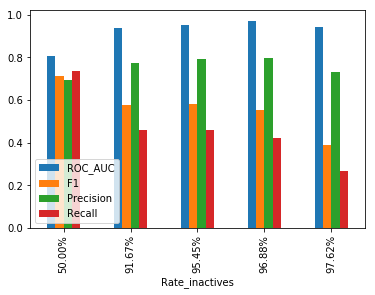

In [12]:
_ = pd.DataFrame(morgan_data_sizes)
vals = _['Rate_inactives']
ax = _.plot.bar(x='Rate_inactives',y=['ROC_AUC','F1','Precision','Recall'])
leg = ax.legend(loc='lower left')
#lab = ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
lab = ax.set_xticklabels(['{:.2%}'.format(x) for x in vals])

### RDKit Fingerprints

In [13]:
step=10
rdkit_data_sizes = compare_data_sizes(testRF,X_rdkit,y,n_actives=829,n_models=50,step=10)

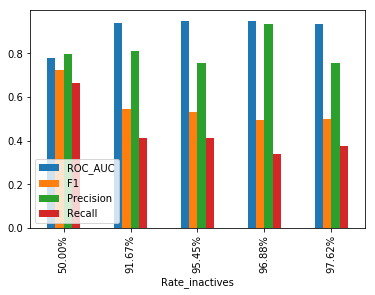

In [14]:
_ = pd.DataFrame(rdkit_data_sizes)
vals = _['Rate_inactives']
ax = _.plot.bar(x='Rate_inactives',y=['ROC_AUC','F1','Precision','Recall'])
leg = ax.legend(loc='lower left')
#lab = ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
lab = ax.set_xticklabels(['{:.2%}'.format(x) for x in vals])

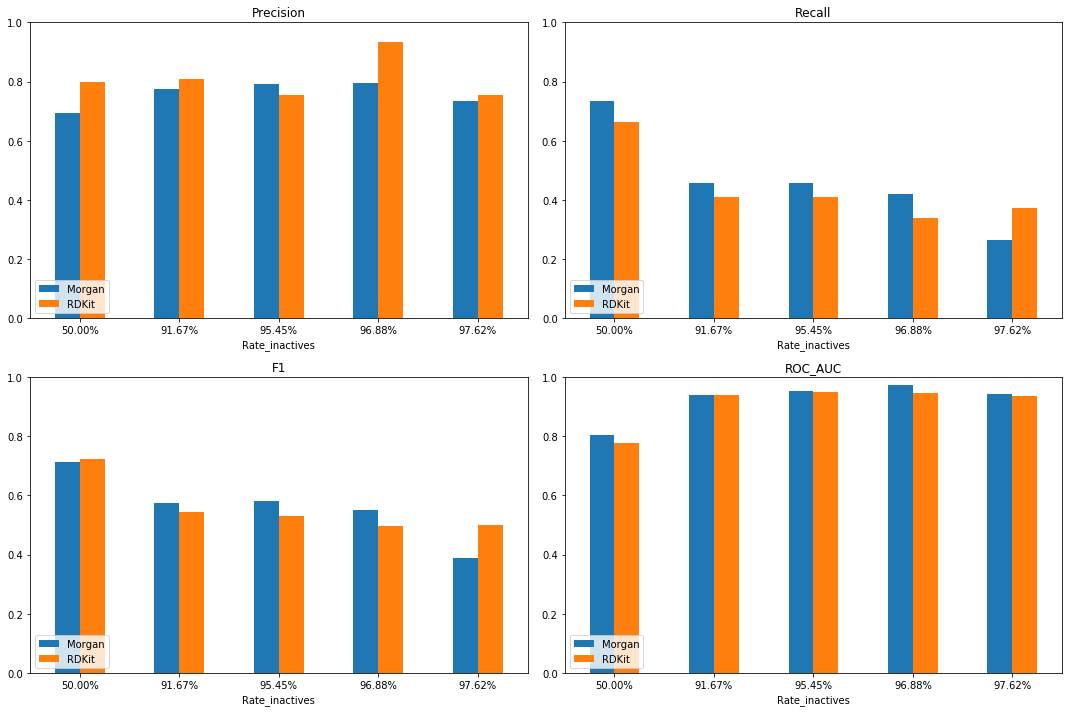

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for axis,prop in zip([(0,0),(0,1),(1,0),(1,1)],['Precision','Recall','F1','ROC_AUC']):
# Precisions
    _ = {'Rate_inactives':morgan_data_sizes['Rate_inactives'],
         'Morgan':morgan_data_sizes[prop],
         'RDKit':rdkit_data_sizes[prop]}
    a=pd.DataFrame(data=_).plot.bar(x='Rate_inactives', y=['Morgan','RDKit'], ax=ax[axis])
    lab = a.set_xticklabels(['{:.2%}'.format(x) for x in vals], rotation=0)
    a.legend(loc='lower left')
    a.set_title(prop)
    a.set_ylim([0,1])
plt.tight_layout()

**Conclusion**

In all cases, the values are mostly converged with about 90% inactives.

**From now on, we will use a rate of 90% inactives.**

## Train / Test split

From now on, we want to find the best parameters in each case, and to compare the Morgan and RDKit results using the best fit parameters. So, let's make the train/test split here, and use the same sets for all tests from now on.

In [25]:
data.head()

,PUBCHEM_SID,RDKit Fingerprints,Morgan Fingerprints,ActiveBit
0,46501256,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
1,26671489,"[1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
2,50086104,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...",True
3,99356103,"[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
4,92764075,"[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True


In [100]:
# This split will return the indices for X, and the y values
X_data = data.index
y_data = data['ActiveBit'].values
X_train_index, X_test_index, y_train, y_test = train_test_split_data(X_data, y_data, rate_inactives=0.90)

X_train:  7461 	y_train:  7461 	( 746 actives and 6715 inactives)
X_test:   829  	y_test:   829  	( 83 actives and 746 inactives)


In [101]:
sum(data.iloc[X_train_index]['ActiveBit'] == y_train), sum(data.iloc[X_test_index]['ActiveBit'] == y_test)

(7461, 829)

# Morgan Fingerprints

## Data

In [102]:
# Select Morgan Fingerprints
X_train_morgan = np.array(list(data.iloc[X_train_index]['Morgan Fingerprints'])).astype(int)
X_test_morgan  = np.array(list(data.iloc[X_test_index]['Morgan Fingerprints'])).astype(int)

In [103]:
X_train_morgan.shape, y_train.shape

((7461, 2048), (7461,))

## Hyperparameter tuning

Thorough optimization using 5-fold cross validation.

In [104]:
# This grid will have 96 different combinations. 
# Using 5-fold cross validation, it sums to 480 fittings.

n_estimators=[150,250,350,450] # Number of estimators
criterion=['gini','entropy']
max_features=[None,0.33,'sqrt']
bootstrap=[True,False]
class_weight=['balanced','balanced_subsample']

## Create the random grid
param_grid = {'n_estimators': n_estimators,
              'criterion': criterion,
              'max_features': max_features,
              'bootstrap':bootstrap,
              'class_weight': class_weight}

In [105]:
model = RandomForestClassifier(random_state=42, n_jobs=4)
scoring = {'F1 Score': make_scorer(f1_score),
           'Precision':make_scorer(precision_score),
           'Recall':make_scorer(recall_score),
           'AUC': 'roc_auc'}

gs = GridSearchCV(estimator=model, param_grid=param_grid,
                  scoring=scoring, refit='Precision',
                  cv=5, verbose=2)

gs.fit(X_train_morgan, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150, total= 1.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150, total= 1.6min
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150, total= 1.7min
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150, total= 1.6min
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150, total= 1.6min
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=250 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_fe

[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_features=None, n_estimators=450, total= 2.8min
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_features=None, n_estimators=450 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_features=None, n_estimators=450, total= 2.8min
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_features=0.33, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_features=0.33, n_estimators=150, total=  20.1s
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_features=0.33, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_features=0.33, n_estimators=150, total=  19.7s
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_features=0.33, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_features=0.33, n_estimators=150, total=  22.6s
[CV] bootstrap=True, clas

[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=350 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=350, total= 1.0min
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=350 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=350, total= 1.0min
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=350 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=350, total=  59.4s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=450 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=450, total= 1.3min
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0

[CV] bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=150, total=   3.5s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=150, total=   3.4s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=150, total=   3.5s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=250 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=250, total=   6.4s
[CV] bootstrap=True, class_weight=balanced_subsample, criter

[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=450 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=450, total=  15.1s
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=450 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=450, total=  14.9s
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=450 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=450, total=  16.1s
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, max_features=None, n_estimators=150 
[CV]  bootstrap=False, class_weight=balanced, criterion=entropy, max_features=None, n_estimators=150, total= 1.8min
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, max_features=None, n_estimators=150 
[CV]  bootstrap=False, class_weight=balanced, cri

[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=350, total= 5.3min
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=350 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=350, total= 6.3min
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=350 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=350, total= 6.7min
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=350 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=350, total= 6.3min
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=450 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_

[CV] bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150, total=  34.4s
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150, total=  38.0s
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150, total=  35.9s
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150, total=  34.6s
[CV] bootstrap=False, class_weight=balanced_subsampl

[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 744.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [150, 250, 350, 450], 'criterion': ['gini', 'entropy'], 'max_features': [None, 0.33, 'sqrt'], 'bootstrap': [True, False], 'class_weight': ['balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit='Precision',
       return_train_score='warn',
       scoring={'F1 Score': make_scorer(f1_score), 'Precision': make_scorer(precision_score), 'Recall': make_scorer(recall_score), 'AUC': 'roc_auc'},
       verbose=2)

In [106]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    df_morgan_opt = pd.DataFrame(gs.cv_results_)
    
df_morgan_opt['Fingerprint'] = "Morgan"
df_morgan_opt.to_csv(path_or_buf='./morgan_opt.csv')
df_morgan_opt.to_pickle('./morgan_opt.pkl.bz2')

df_morgan_opt.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_class_weight,param_criterion,param_max_features,param_n_estimators,params,...,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,split2_train_AUC,split3_train_AUC,split4_train_AUC,mean_train_AUC,std_train_AUC,Fingerprint
0,97.632134,2.680090,0.456473,0.007467,True,balanced,gini,None,150,"{'bootstrap': True, 'class_weight': 'balanced'...",...,0.010647,75,0.999948,0.999964,0.999964,1.0,1.0,0.999975,0.000021,Morgan
1,158.858815,3.343530,0.476449,0.045213,True,balanced,gini,None,250,"{'bootstrap': True, 'class_weight': 'balanced'...",...,0.010407,70,0.999955,0.999968,0.999964,1.0,1.0,0.999977,0.000019,Morgan
2,208.584575,6.962614,0.514671,0.125014,True,balanced,gini,None,350,"{'bootstrap': True, 'class_weight': 'balanced'...",...,0.010104,67,0.999960,0.999974,0.999972,1.0,1.0,0.999981,0.000016,Morgan
3,252.727259,5.606996,0.855076,0.000711,True,balanced,gini,None,450,"{'bootstrap': True, 'class_weight': 'balanced'...",...,0.010396,68,0.999957,0.999969,0.999966,1.0,1.0,0.999978,0.000018,Morgan
4,26.515650,0.932962,0.451406,0.001214,True,balanced,gini,0.33,150,"{'bootstrap': True, 'class_weight': 'balanced'...",...,0.011324,57,0.999962,0.999967,0.999971,1.0,1.0,0.999980,0.000017,Morgan


The best combination of parameters, according to the grid search:

In [107]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=350, n_jobs=4, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

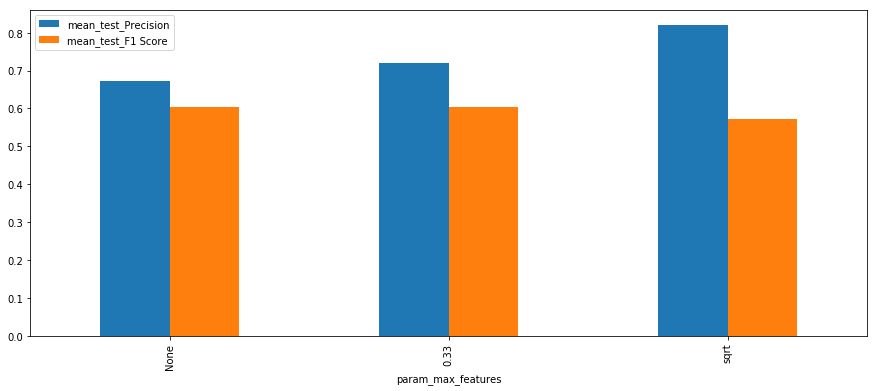

In [122]:
# Stats for the best estimator
_ = (df_morgan_opt['param_bootstrap'] == True) & \
    (df_morgan_opt['param_class_weight'] == 'balanced_subsample') & \
    (df_morgan_opt['param_criterion'] == 'entropy') & \
    (df_morgan_opt['param_max_features'] == 'sqrt') & \
    (df_morgan_opt['param_n_estimators'] == 350)
df_morgan_opt.loc[_].plot.bar(x='param_max_features', y=['mean_test_Precision', 'mean_test_F1 Score'], figsize=(15,6))
#df_morgan_opt.loc[_]

In [109]:
chosen_rf_morgan = gs.best_estimator_
chosen_rf_morgan

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=350, n_jobs=4, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

# RDKit Fingerprints

## Data

In [110]:
# Select RDKit Fingerprints
X_train_rdkit = np.array(list(data.iloc[X_train_index]['RDKit Fingerprints'])).astype(int)
X_test_rdkit  = np.array(list(data.iloc[X_test_index]['RDKit Fingerprints'])).astype(int)

In [111]:
X_train_rdkit.shape, y_train.shape

((7461, 2048), (7461,))

## Hyperparameter tuning

Thorough optimization using 5-fold cross validation.

In [112]:
model = RandomForestClassifier(random_state=42, n_jobs=4)
scoring = {'F1 Score': make_scorer(f1_score),
           'Precision':make_scorer(precision_score),
           'Recall':make_scorer(recall_score),
           'AUC': 'roc_auc'}

gs = GridSearchCV(estimator=model, param_grid=param_grid,
                  scoring=scoring, refit='Precision',
                  cv=5, verbose=2)

gs.fit(X_train_rdkit, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150, total=  40.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.1s remaining:    0.0s


[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150, total=  38.3s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150, total=  38.9s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150, total=  37.7s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=150, total=  38.2s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_features=None, n_estimators=250 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_fe

[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_features=None, n_estimators=450, total= 1.8min
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_features=None, n_estimators=450 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_features=None, n_estimators=450, total= 1.9min
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_features=0.33, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_features=0.33, n_estimators=150, total=  14.6s
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_features=0.33, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_features=0.33, n_estimators=150, total=  14.0s
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_features=0.33, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_features=0.33, n_estimators=150, total=  13.8s
[CV] bootstrap=True, clas

[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=350 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=350, total=  32.6s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=350 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=350, total=  31.7s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=350 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=350, total=  32.6s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=450 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0.33, n_estimators=450, total=  41.1s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_features=0

[CV] bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=150, total=   2.1s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=150, total=   2.1s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=150 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=150, total=   2.1s
[CV] bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=250 
[CV]  bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=250, total=   3.2s
[CV] bootstrap=True, class_weight=balanced_subsample, criter

[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=450 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=450, total=   8.2s
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=450 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=450, total=   8.1s
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=450 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=450, total=   8.2s
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, max_features=None, n_estimators=150 
[CV]  bootstrap=False, class_weight=balanced, criterion=entropy, max_features=None, n_estimators=150, total= 1.1min
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, max_features=None, n_estimators=150 
[CV]  bootstrap=False, class_weight=balanced, cri

[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=350, total= 2.5min
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=350 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=350, total= 2.5min
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=350 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=350, total= 2.5min
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=350 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=350, total= 2.4min
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_features=None, n_estimators=450 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=gini, max_

[CV] bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150, total=  23.1s
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150, total=  23.3s
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150, total=  23.7s
[CV] bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150 
[CV]  bootstrap=False, class_weight=balanced_subsample, criterion=entropy, max_features=0.33, n_estimators=150, total=  23.5s
[CV] bootstrap=False, class_weight=balanced_subsampl

[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 390.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [150, 250, 350, 450], 'criterion': ['gini', 'entropy'], 'max_features': [None, 0.33, 'sqrt'], 'bootstrap': [True, False], 'class_weight': ['balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit='Precision',
       return_train_score='warn',
       scoring={'F1 Score': make_scorer(f1_score), 'Precision': make_scorer(precision_score), 'Recall': make_scorer(recall_score), 'AUC': 'roc_auc'},
       verbose=2)

In [113]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    df_rdkit_opt = pd.DataFrame(gs.cv_results_)
    
df_rdkit_opt['Fingerprint'] = "RDKit"
df_rdkit_opt.to_csv(path_or_buf='./rdkit_opt.csv')
df_rdkit_opt.to_pickle('./rdkit_opt.pkl.bz2')

df_rdkit_opt.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_class_weight,param_criterion,param_max_features,param_n_estimators,params,...,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,split2_train_AUC,split3_train_AUC,split4_train_AUC,mean_train_AUC,std_train_AUC,Fingerprint
0,38.291902,0.834929,0.450875,0.001074,True,balanced,gini,None,150,"{'bootstrap': True, 'class_weight': 'balanced'...",...,0.008432,48,0.999830,0.999970,0.999916,0.999870,0.999924,0.999902,0.000048,RDKit
1,63.063664,0.722598,0.451390,0.001023,True,balanced,gini,None,250,"{'bootstrap': True, 'class_weight': 'balanced'...",...,0.010449,42,0.999817,0.999973,0.999925,0.999869,0.999934,0.999903,0.000055,RDKit
2,87.258486,0.296383,0.471239,0.040750,True,balanced,gini,None,350,"{'bootstrap': True, 'class_weight': 'balanced'...",...,0.010255,36,0.999831,0.999983,0.999932,0.999872,0.999942,0.999912,0.000054,RDKit
3,112.010589,0.723698,0.633238,0.134951,True,balanced,gini,None,450,"{'bootstrap': True, 'class_weight': 'balanced'...",...,0.010674,37,0.999823,0.999971,0.999921,0.999872,0.999930,0.999903,0.000051,RDKit
4,13.863299,0.276404,0.450644,0.000695,True,balanced,gini,0.33,150,"{'bootstrap': True, 'class_weight': 'balanced'...",...,0.009332,38,0.999827,0.999962,0.999930,0.999870,0.999922,0.999902,0.000048,RDKit


The best combination of parameters, according to the grid search:

In [114]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=None, max_features=0.33,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=4, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

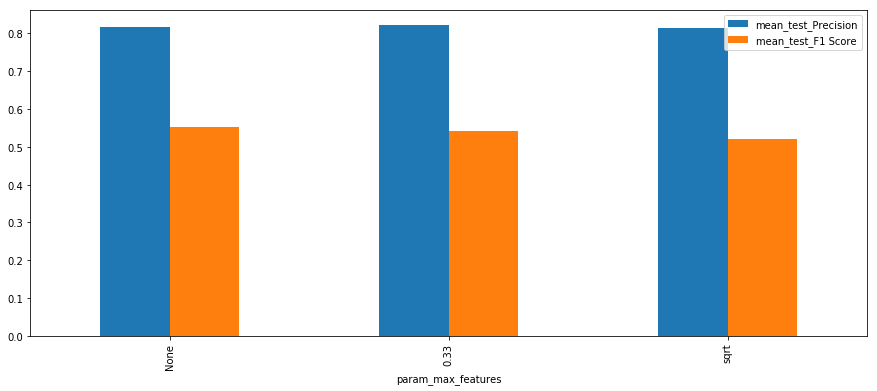

In [129]:
# Stats for the best estimator
_ = (df_rdkit_opt['param_bootstrap'] == True) & \
    (df_rdkit_opt['param_class_weight'] == 'balanced_subsample') & \
    (df_rdkit_opt['param_criterion'] == 'entropy') & \
    (df_rdkit_opt['param_max_features'] == '0.33') & \
    (df_rdkit_opt['param_n_estimators'] == 150)
df_rdkit_opt.loc[_].plot.bar(x='param_max_features', y=['mean_test_Precision', 'mean_test_F1 Score'], figsize=(15,6))

In [116]:
chosen_rf_rdkit = gs.best_estimator_
chosen_rf_rdkit

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=None, max_features=0.33,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=4, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

# Test

## Morgan Fingerprints

In [117]:
X_test_morgan.shape, y_test.shape

((829, 2048), (829,))

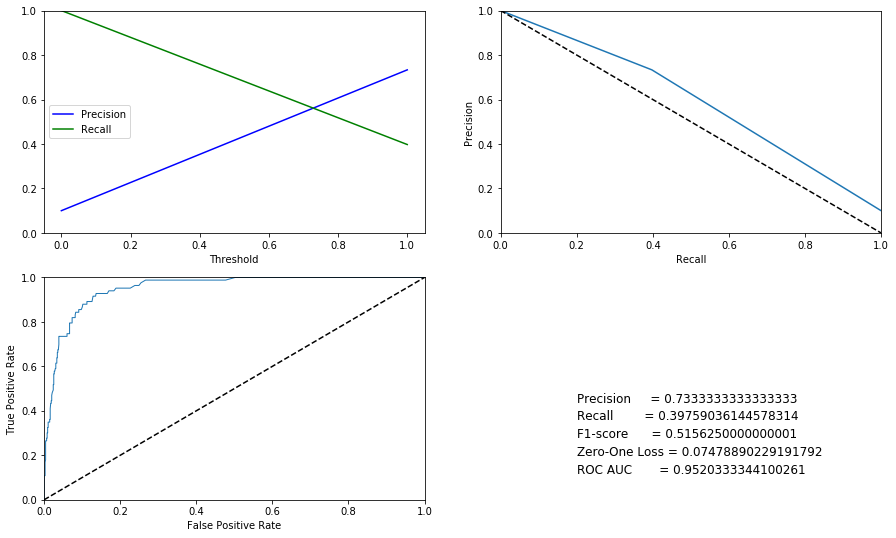

In [118]:
#chosen_rf_morgan.fit(X_train_morgan,y_train)
morgan_stats = evaluate_model(chosen_rf_morgan, X_test_morgan, y_test)
morgan_stats["Fingerprint"] = "Morgan"

## RDKit Fingerprints

In [119]:
X_test_rdkit.shape, y_test.shape

((829, 2048), (829,))

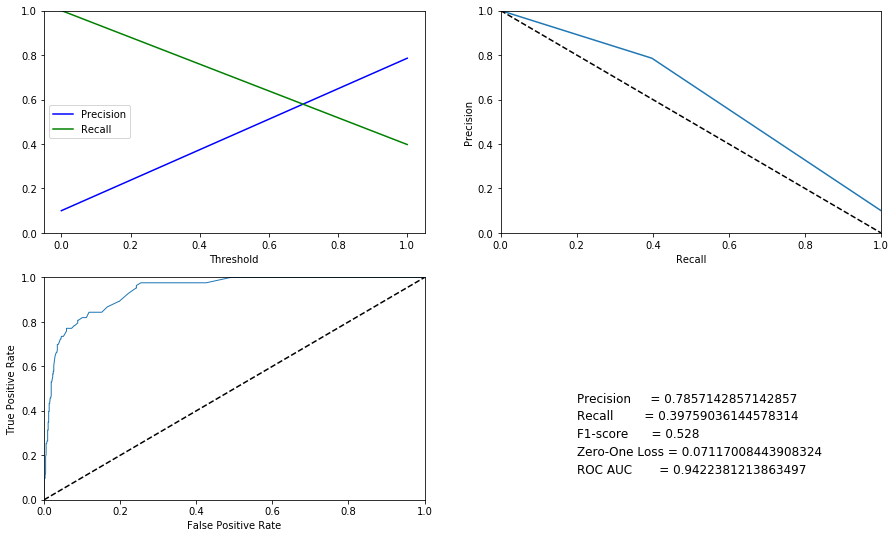

In [120]:
#chosen_rf_rdkit.fit(X_train_rdkit,y_train)
rdkit_stats = evaluate_model(chosen_rf_rdkit, X_test_rdkit, y_test)
rdkit_stats["Fingerprint"]="RDKit"

## Comparison

Text(0.5, 1.0, 'Test Set')

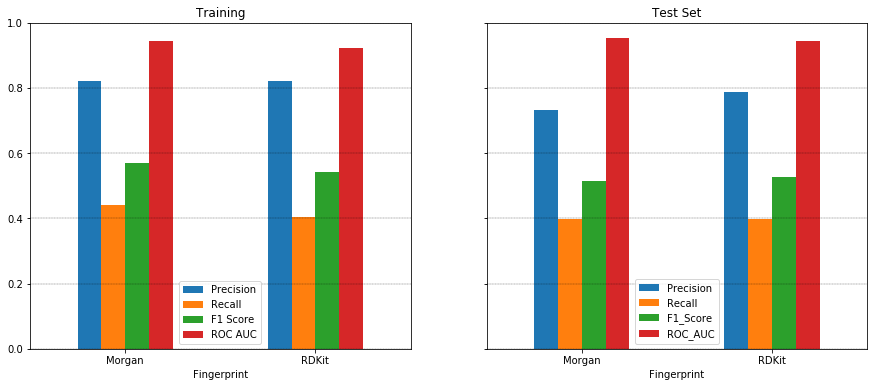

In [256]:
x_col = ['Fingerprint']
y_cols = ['mean_test_Precision', 'mean_test_Recall','mean_test_F1 Score', 'mean_test_AUC']
stdev_cols = ['std_test_Precision', 'std_test_Recall','std_test_F1 Score', 'std_test_AUC']
col_names = ['Precision','Recall','F1 Score','ROC AUC']

# Stats for the best estimators

# Training data (test split from 5-fold CV)
# ------------------------------------------------------------------
# Morgan
_ = (df_morgan_opt['param_bootstrap'] == True) & \
    (df_morgan_opt['param_class_weight'] == 'balanced_subsample') & \
    (df_morgan_opt['param_criterion'] == 'entropy') & \
    (df_morgan_opt['param_max_features'] == 'sqrt') & \
    (df_morgan_opt['param_n_estimators'] == 350)
training_stats = df_morgan_opt.loc[_].filter(x_col + y_cols)
stdev = df_morgan_opt.loc[_].filter(stdev_cols)

# RDKit
_ = (df_rdkit_opt['param_bootstrap'] == True) & \
    (df_rdkit_opt['param_class_weight'] == 'balanced_subsample') & \
    (df_rdkit_opt['param_criterion'] == 'entropy') & \
    (df_rdkit_opt['param_max_features'] == 0.33) & \
    (df_rdkit_opt['param_n_estimators'] == 150)
training_stats = training_stats.append(df_rdkit_opt[_].filter(x_col + y_cols))
stdev = stdev.append(df_rdkit_opt[_].filter(stdev_cols))

training_stats.columns = x_col + col_names
stdev.columns = col_names

# Now, plot the data
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)

# Training data
training_stats.plot.bar(x='Fingerprint', y=col_names, yerr=stdev, ax=ax[0])
ax[0].yaxis.grid(which="major", color='k', linestyle='--', linewidth=0.3)
ax[0].xaxis.set_tick_params(rotation=0)
ax[0].legend(loc='best')
ax[0].set_title("Training")

# Statistics obtained from the test set
# Test data
# ------------------------------------------------------------------
pd.DataFrame(morgan_stats).append(pd.DataFrame(rdkit_stats)).drop('Zero-on', axis=1).plot.bar(x='Fingerprint', ax=ax[1])
ax[1].xaxis.set_tick_params(rotation=0)
ax[1].yaxis.grid(which="major", color='k', linestyle='--', linewidth=0.3)
ax[1].legend(loc='lower center')
ax[1].set_title("Test Set")

# Conclusion

Both fingerprints seem to give about the same result. However, the RDKit fingerprint seems a bit more robust on the testing set, so we should use this from now on.

In [257]:
chosen_rf_rdkit

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=None, max_features=0.33,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=4, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [259]:
y_test_pred_rdkit = cross_val_predict(chosen_rf_rdkit,X_test_rdkit,y_test, verbose=1, cv=5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.0s finished
